# Import

In [1]:
# ignore deprecation warnings in sklearn
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.metrics import accuracy_score
from scipy.stats import randint
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer

pd.options.display.max_rows = 100
# plt.rcParams['figure.figsize'] = (16,12)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.__version__

'0.25.3'

# Fonctions d'automatisation et de simplification 

In [2]:
###### retourne la racine de l'erreur quadratique moyenne au carré ( RMSE) RootMeanSquared
def RMSE(y_pred, y_test):
    rmse = (mean_squared_error(y_pred, y_test))**1 / 2
    return rmse
#------------------------------------------------------------------------------------------------------

# scale and train the model, also print the train and test score(r²)
def scale_train_test(model, scaler, X_train, y_train, X_test, y_test):
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model.fit(X_train_scaled, y_train)
    print("train score:", model.score(X_train_scaled, y_train))
    print("test score:", model.score(X_test_scaled, y_test))
    return None
#------------------------------------------------------------------------------------------------------

# print out importances features (bar plot horiz)
def print_importance_features(model, index):
    # Create a pd.Series of features importances
    importances = pd.Series(data=model.feature_importances_, index=index)

    # Sort importances
    importances_sorted = importances.sort_values()
    importances_sorted_toplot = importances_sorted[importances_sorted >= 0.5 *  # trick to print just some most important features
                                                   importances.mean()]

    # Draw a horizontal barplot of importances_sorted
    importances_sorted_toplot.plot(kind='barh', color='lightgreen')
    plt.title('Features Importances')
    plt.show()
    return importances

#------------------------------------------------------------------------------------------------------
# return feature importance as dataframe
def df_features_importance(model,index):
    return pd.Series(data=model.feature_importances_, index=index)

#------------------------------------------------------------------------------------------------------
# call 2 functions to simplify code more
def scale_train_importance_print(model, scaler, X_train, y_train, X_test,
                                 y_test):
    scale_train_test(model, scaler, X_train, y_train, X_test, y_test)
    print_importance_features(model, X_train.columns)
    return None
#------------------------------------------------------------------------------------------------------

# Prepare data to build Machine Learning Models

In [3]:
#Read processed Data 

df_imputed = pd.read_csv('processed_data.csv')

# Select target and features 
X = df_imputed.drop(['SiteEnergyUse(kBtu)'],axis=1)
y = df_imputed['SiteEnergyUse(kBtu)']

#split data into train,test (80,20)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)


# Standardization
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)




# MODELE 1 (Lasso) : Selecting features with L1 regularization 

In [4]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

lasso = Lasso(alpha=20,random_state=7)
lasso = lasso.fit(X_train_scaled,y_train)
model = SelectFromModel(lasso, prefit=True)
X_regularised = model.transform(X_train_scaled)

In [5]:
print ("train score:",lasso.score(X_train_scaled,y_train))
print ("test score:",lasso.score(X_test_scaled,y_test))


train score: 0.9994984823957594
test score: 0.9499983704502999


In [6]:
selected_features = pd.DataFrame(model.inverse_transform(X_regularised),
                                 index=X_train.index,
                                 columns=X_train.columns)



selected_columns = selected_features.columns[selected_features.var() != 0]

features =selected_features[selected_columns]

print("Avant Lasso:",X_train.shape)
print("Aprés Lasso:",features.shape)



Avant Lasso: (5372, 43)
Aprés Lasso: (5372, 41)


### Le but principal de ce Lasso est de réduire le nombres de variables corrélées et simplifier le modéle en affectant un poids 0 aleatoires a l'une des variables correlées et au meme temps detecter le data leak.

### On voit bien que dans ce cas on a réduit la dimension que de deux features meme avec un alpha assez grand donc ce n'ai pas trés interessant d'utiliser un Lasso car on veut avant tout reduire le nombre de variables et detecter la fuite de données, on continue donc sans la regularisation par norme L1 on se tournant vers un modéle ensembliste

## MODELE 2 (RF) : Random Forests Algorithm

#### Visualisation de l'importances des features 

train score: 0.9948946726369524
test score: 0.38233531273118093


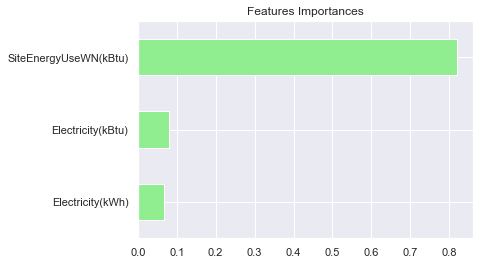

In [7]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state=7,max_depth=7)

scale_train_importance_print(rf, scaler, X_train, y_train, X_test, y_test)

### On remarque une fuite de données ce qui est tout a fait normal car ce sont des variables qui ont pour unité kBtu et Kwh et en physique cela signifie la meme chose juste une unité différente, en realité on a  essayer de prédire une target alors qu'elles font partie des features ! et on appelle ca une fuite de données, donc on doit enlever toutes les features qui concerne la production electrique et on refait le test 

train score: 0.9379352677545328
test score: 0.8140592702474714


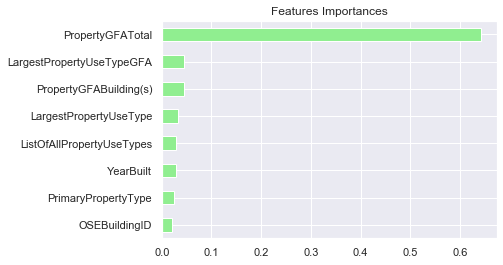

In [8]:
# we remove data leakage, prohibited data
data_leakage = [
    'SiteEUI(kBtu/sf)','ENERGYSTARScore', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)',
    'SourceEUIWN(kBtu/sf)', 'SteamUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)',
    'TotalGHGEmissions', 'NaturalGas(kBtu)','NaturalGas(therms)','GHGEmissionsIntensity(kgCO2e/ft2)', 'OtherFuelUse(kBtu)',
    'GHGEmissionsIntensity','SiteEnergyUse(kBtu)','SiteEnergyUseWN(kBtu)','Electricity(kBtu)','Electricity(kWh)'
]

# we convert the target to Log because we saw earlier its makes it much better
target_log = np.log(df_imputed['SiteEnergyUse(kBtu)'])


X = df_imputed.drop(data_leakage,axis=1)
y = target_log

#split data into train,test (80,20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Standardization
scaler = StandardScaler()

# Random Forests
rf = RandomForestRegressor(n_estimators=300,n_jobs=-1,random_state=10,max_depth=12)

scale_train_importance_print(rf, scaler, X_train, y_train, X_test, y_test)

# Random forest ( 2nd Target : CO2)

train score: 0.9126787954254051
test score: 0.6882008240922108


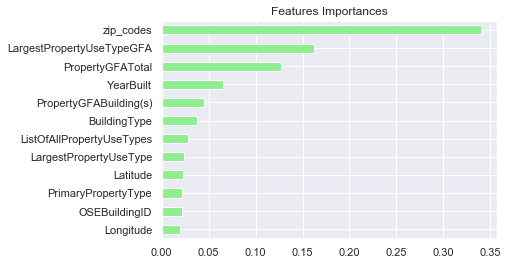

In [9]:
# instantiate new Random Forests
rf = RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state=7,max_depth=12)

#calc the log target
target_log= np.log(df_imputed['TotalGHGEmissions'])

X = df_imputed.drop(data_leakage,axis=1)
y = target_log
    
#split data into train,test (80,20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Standardization
scaler = StandardScaler()

scale_train_importance_print(rf, scaler, X_train, y_train, X_test, y_test) 

# MODELE FINAL : MODELE 3 ( XGBOOST Algorithm )


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.8s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=-1, nthread=None,
                                          objective='reg:squarederror',
                                          random_state=0, reg...
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                     

train score: 0.9934026108828605
test score: 0.8649368438953077


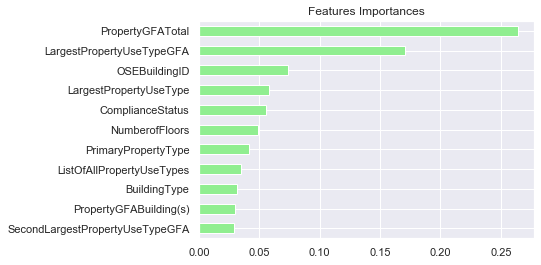

In [10]:
from sklearn.metrics import r2_score
import xgboost as xgb
from xgboost import plot_importance


#instantiate XGB Regressor
xgbr = xgb.XGBRegressor(n_jobs=-1,objective='reg:squarederror')

#Hyper Parameter Optimization
params = {
   "learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    "max_depth": [3, 6, 8, 15, 30],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
    "colsample_bytree": [0.3, 0.4, 0.5, 0.7],
    "n_estimators" : [100,200,300,400]
    
    
}
#----------------------------------------------------
# 3%
#   "learning_rate": [0.07], # 0.07
#     "max_depth": [6],  # 6 
#     "min_child_weight": [15], # 4
#     "gamma": [5], # 0.1
#     "colsample_bytree": [0.4,0.5] # 0.5
#----------------------------------------------------
random_search = RandomizedSearchCV(xgbr,
                                   param_distributions=params,
                                   scoring='neg_mean_absolute_error',
                                   n_jobs=-1,cv=5,verbose=3)

# we convert the target to Log because we saw earlier its makes it much better
target_log = np.log(df_imputed['SiteEnergyUse(kBtu)'])


X = df_imputed.drop(data_leakage,axis=1)
y = target_log

#split data into train,test (80,20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=7)

# Standardization
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


random_search.fit(X_train_scaled,y_train)
y_pred_test = random_search.predict(X_test_scaled)
y_pred_train = random_search.predict(X_train_scaled)

best_model = random_search.best_estimator_


print("train score:", r2_score(y_train,y_pred_train))
print("test score:", r2_score(y_test,y_pred_test))
important_features = print_importance_features(best_model, X_train.columns)


## Selection des features les plus importantes et optimisation manuelle 

In [18]:
selected_features = []

for feature in range(len(important_features.index)):
    if important_features[feature] >= important_features.mean():
        selected_features.append(important_features.index[feature])



#instantiate XGB Regressor
xgbr = xgb.XGBRegressor(n_jobs=-1,objective='reg:squarederror')

#Hyper Parameter Optimization
params = {
    "learning_rate": [0.07], # 0.07
    "max_depth": [12],  # 6 
    "min_child_weight": [5], # 4
    "gamma": [0.5], # 0.1
    "colsample_bytree": [0.5],# 0.5
    "n_estimators": [600]
}

#----------------------------------------------------
#best parameters :
# "learning_rate": [0.07], # 0.07
#     "max_depth": [6],  # 6 
#     "min_child_weight": [15], # 4
#     "gamma": [0.5], # 0.1
#     "colsample_bytree": [0.5],# 0.5
#     "n_estimators": [500]
#----------------------------------------------------
# 3%
#   "learning_rate": [0.07], # 0.07
#     "max_depth": [6],  # 6 
#     "min_child_weight": [15], # 4
#     "gamma": [5], # 0.1
#     "colsample_bytree": [0.4,0.5] # 0.5
#----------------------------------------------------
random_search = RandomizedSearchCV(xgbr,
                                   param_distributions=params,
                                   scoring='neg_mean_absolute_error',
                                   n_jobs=-1,cv=5,verbose=3)

# we convert the target to Log because we saw earlier its makes it much better
target_log = np.log(df_imputed['SiteEnergyUse(kBtu)'])


X = df_imputed[selected_features]
y = target_log

#split data into train,test (80,20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=7)

# Standardization
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


random_search.fit(X_train_scaled,y_train)
y_pred_test = random_search.predict(X_test_scaled)
y_pred_train = random_search.predict(X_train_scaled)



Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=-1, nthread=None,
                                          objective='reg:squarederror',
                                          random_state=0, reg...
                                          seed=None, silent=None, subsample=1,
                                          verbosity=1),
                   iid='deprecated', n_iter=10, n_job

In [19]:
print("train score:", r2_score(y_train,y_pred_train))
print("test score:", r2_score(y_test,y_pred_test))
random_search.best_params_

train score: 0.9303195605123143
test score: 0.8359618690312011


{'n_estimators': 600,
 'min_child_weight': 5,
 'max_depth': 12,
 'learning_rate': 0.07,
 'gamma': 0.5,
 'colsample_bytree': 0.5}

Text(0.5, 0, 'Valeur réelle')

Text(0, 0.5, 'Valeur prédite')

Text(0.5, 1.0, 'comportement du modéle')

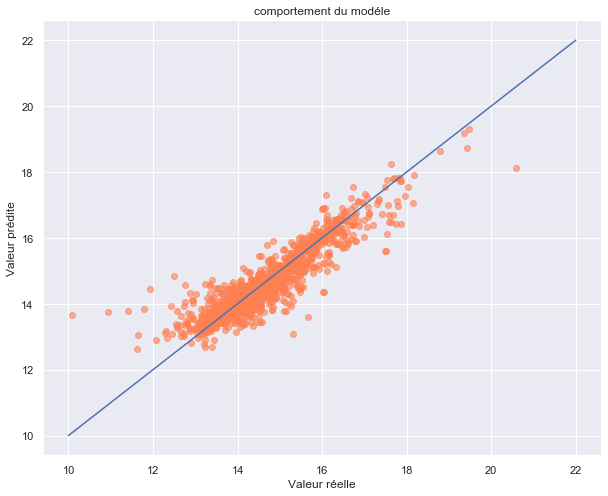

In [20]:
plt.rcParams['figure.figsize'] = (10,8)
plt.scatter(y_test,y_pred_test,alpha=0.6,c='coral')
plt.xlabel('Valeur réelle')
plt.ylabel('Valeur prédite')
plt.title("comportement du modéle")
x = np.linspace(10, 22, 1000)
y = np.linspace(10, 22, 1000)
plt.plot(x,y)

# XGBOOST (2nd target Co2)

In [14]:
#instantiate XGB Regressor
xgbr = xgb.XGBRegressor(n_jobs=-1,objective='reg:squarederror')


#Hyper Parameter Optimization
params = {
    "learning_rate": [0.07],
    "max_depth": [6], # 3
    "min_child_weight": [12],
    "gamma": [12],
    "colsample_bytree": [0.7],
    "n_estimators": [300] 
}


# "learning_rate": [0.09],
#     "max_depth": [4],
#     "min_child_weight": [8],
#     "gamma": [0.2],
#     "colsample_bytree": [0.5],


# "learning_rate": [0.05,0.10, 0.15, 0.20, 0.25, 0.30],
#     "max_depth": [4,5,6, 8, 15,20,25],
#     "min_child_weight": [1, 3, 5, 7],
#     "gamma": [0.0, 0.1, 0.2],
#     "colsample_bytree": [0.3, 0.4, 0.5, 0.7]
        
random_search = RandomizedSearchCV(xgbr,
                                   param_distributions=params,
                                   scoring='neg_mean_absolute_error',
                                   n_jobs=-1,cv=5,verbose=3)

# we convert the target to Log because we saw earlier its makes it much better
target_log = np.log(df_imputed['TotalGHGEmissions'])


X = df_imputed.drop(data_leakage,axis=1)
y = target_log

#split data into train,test (80,20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=7)

# Standardization
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


random_search.fit(X_train_scaled,y_train)
y_pred_test = random_search.predict(X_test_scaled)
y_pred_train = random_search.predict(X_train_scaled)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=-1, nthread=None,
                                          objective='reg:squarederror',
                                          random_state=0, reg...
                                          seed=None, silent=None, subsample=1,
                                          verbosity=1),
                   iid='deprecated', n_iter=10, n_job

In [15]:
print("train score:", r2_score(y_train,y_pred_train))
print("test score:", r2_score(y_test,y_pred_test))
RMSE(y_pred_test, y_test)


train score: 0.7549155689037115
test score: 0.7013739587922807


0.23346628365188254

In [16]:
random_search.best_params_
best_model = random_search.best_estimator_

{'n_estimators': 300,
 'min_child_weight': 12,
 'max_depth': 6,
 'learning_rate': 0.07,
 'gamma': 12,
 'colsample_bytree': 0.7}

Text(0.5, 0, 'Valeur réelle')

Text(0, 0.5, 'Valeur prédite')

Text(0.5, 1.0, 'comportement du modéle')

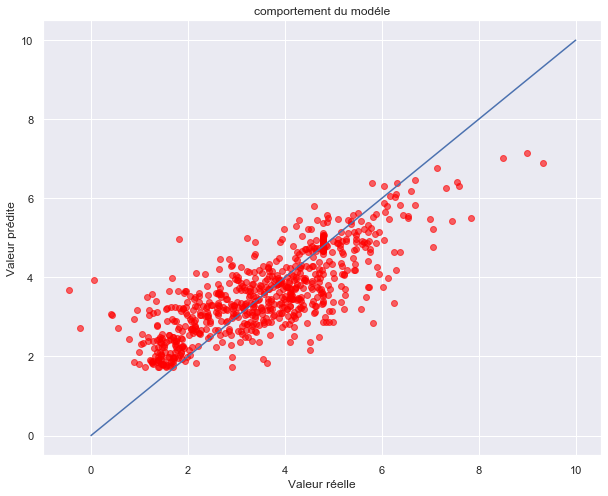

In [17]:
plt.rcParams['figure.figsize'] = (10,8)
plt.scatter(y_test,y_pred_test,alpha=0.6,c='red')
plt.xlabel('Valeur réelle')
plt.ylabel('Valeur prédite')
plt.title("comportement du modéle")
x = np.linspace(0, 10, 1000)
y = np.linspace(0, 10, 1000)
plt.plot(x,y)